In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder

In [2]:
# Load dataset and create DataFrame (assuming the data is in a CSV file called 'data.csv')
df = pd.read_excel('mti_converted_amount.xlsx', sheet_name= 'Sheet1')

In [ ]:
df.columns

In [ ]:
df.shape

In [15]:
def group_procedure(row):
    procedure = row['Procedimiento']
    amount = row['converted_monto']
    
    licitacion_publica = [
        'Licitación Pública',
        'Licitación Pública Internacional',
        'Licitación Pública Nacional',
        'Licitación Pública Internacional Obras'
    ]

    licitacion_selectiva = ['Licitación Selectiva']
    
    contratacion_simplificada = ['Contratación Simplificada']
    
    contrataciones_menores = ['Contrataciones Menores']
    
    por_concurso = [
        'Concurso para la Selección de Consultores',
        'Concurso Público Internacional Consultorías',
        'Concurso Firma Consultora'
    ]

    if procedure in licitacion_publica:
        return 'Licitación Pública'
    elif procedure in licitacion_selectiva:
        return 'Licitación Selectiva'
    elif procedure in contratacion_simplificada:
        return 'Contratación Simplificada'
    elif procedure in contrataciones_menores:
        return 'Contrataciones Menores'
    elif procedure in por_concurso:
        return 'Por Concurso'
    elif 3000000 <= amount:
        return 'Licitación Pública'
    elif 500000 <= amount < 3000000:
        return 'Licitación Selectiva'
    else:
        return 'Other'

df['Procedimiento_Grouped'] = df.apply(group_procedure, axis=1)

In [ ]:
df.head()

In [4]:
# Binary encoding for categorical data
cat_columns = ['Procedimiento','Categoria','Proveedor']
encoder = BinaryEncoder(cols=cat_columns)
df_encoded = encoder.fit_transform(df[cat_columns])

In [5]:
# Normalize numerical data
num_columns = ['converted_monto']
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df[num_columns]), columns=num_columns)

In [6]:
# Combine encoded categorical data and normalized numerical data
df_processed = pd.concat([df_encoded, df_normalized], axis=1)

In [ ]:
# Find optimal number of K using Elbow method
inertia = []
K_range = range(1, 11)  # You can adjust the range according to your needs
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_processed)
    inertia.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método Elbow para K optimo')
plt.show()

In [ ]:
# Run K-means clustering (replace 'optimal_k' with the number you find using the Elbow method)
optimal_k = 3  # Replace with the optimal K value you find from the graph
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(df_processed)

# Add clusters to the original DataFrame
df['Cluster'] = clusters

# Save clustered data to a new CSV file
#df.to_csv('clustered_data.csv', index=False)

In [10]:
# Perform PCA for visualization
pca = PCA(n_components=2)  # Use n_components=3 for a 3D scatter plot
df_pca = pca.fit_transform(df_processed)

# Create a new DataFrame with PCA results and cluster labels
df_pca_clustered = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])  # Add 'PC3' for a 3D scatter plot
df_pca_clustered['Cluster'] = clusters

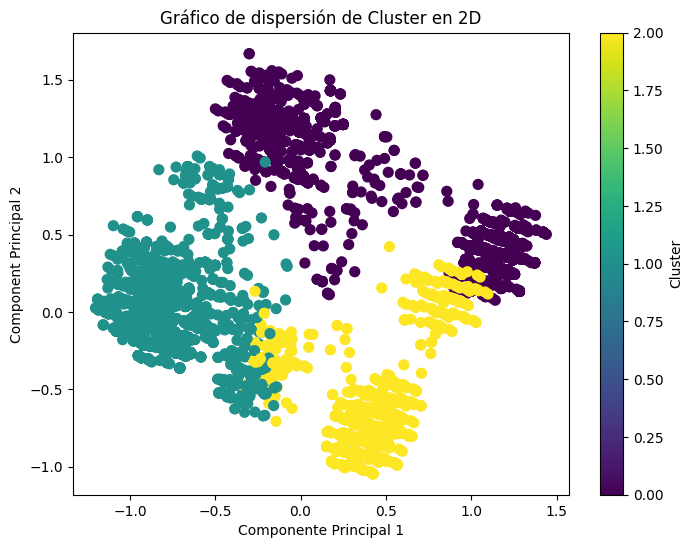

In [11]:
# 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_clustered['PC1'], df_pca_clustered['PC2'], c=df_pca_clustered['Cluster'], cmap='viridis', s=50)
plt.xlabel('Componente Principal 1')
plt.ylabel('Component Principal 2')
plt.title('Gráfico de dispersión de Cluster en 2D')
plt.colorbar().set_label('Cluster')
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Assuming you have already fit your KMeans model
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_processed)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(df_processed, kmeans.labels_)
print("The average silhouette score is:", silhouette_avg)


In [ ]:
import numpy as np

# Get the labels assigned by the KMeans model
labels = kmeans.labels_

# Count the number of data points in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# Create a dictionary of cluster labels and their counts
cluster_counts = dict(zip(unique_labels, counts))

# Print the cluster counts
print("Data points per cluster:", cluster_counts)

# Find the cluster with the most data points
max_cluster = max(cluster_counts, key=cluster_counts.get)
print("The cluster with the most data points is:", max_cluster)


## Attempt 2 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import matplotlib.cm as cm

In [4]:
# Preprocessing: OneHotEncoder for categorical features, StandardScaler for numerical features
categorical_features = ['Procedimiento','Categoria','Proveedor']
numerical_features = ['converted_monto', 'Duracion proceso']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [5]:
# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42, init= 'random')

In [6]:
# Create a pipeline to perform preprocessing, feature selection
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('tsne', tsne)])

In [7]:
# Fit and transform the data
df_processed = pipe.fit_transform(df)

In [ ]:
# Find optimal number of K using Elbow method and Silhouette Score
inertia = []
sil_scores = []
K_range = range(2, 11)  # You can adjust the range according to your needs
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_processed)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(df_processed, kmeans.labels_))

# Plot the Elbow method graph
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.title('Método Elbow para K optimo')
plt.show()

In [ ]:
# Plot the Silhouette Scores
plt.plot(K_range, sil_scores, 'gx-')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Puntaje de Silhouette')
plt.title('Puntaje de Silhouette para diferentes valores de K')
plt.show()

In [ ]:
# Choose the optimal K based on the elbow method and silhouette scores
optimal_k = 6  # Set this value based on your observations of the graphs

# Fit the final KMeans model with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(df_processed)

# Calculate Silhouette Score
silhouette_avg = silhouette_score(df_processed, kmeans.labels_)
print("The average silhouette score is:", silhouette_avg)

In [ ]:
# Get cluster assignments from the KMeans model
cluster_assignments = kmeans.labels_

# Create a scatter plot of the t-SNE transformed data points, colored by cluster assignments
plt.figure(figsize=(10, 8))
colors = cm.nipy_spectral(cluster_assignments.astype(float) / optimal_k)
plt.scatter(df_processed[:, 0], df_processed[:, 1], marker='.', s=50, lw=0, alpha=0.7, c=colors, edgecolor='k')


In [ ]:
# Create a color map for the clusters
colors = ['blue', 'red', 'green', 'orange', 'purple', 'yellow', 'cyan', 'magenta', 'brown', 'black']
color_map = [colors[label] for label in kmeans.labels_]

# Plot the clustered data points with different colors
plt.scatter(df_processed[:, 0], df_processed[:, 1], c=color_map, s=50, alpha=0.5)

# Annotate the plot with cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

plt.title('Visualización de datos en clúster')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


In [ ]:
# Count number of data points in each cluster
labels = kmeans.labels_
counts = np.bincount(labels)

# Print number of data points in each cluster
for i, count in enumerate(counts):
    print(f"Cluster {i}: {count} data points")
    
# Find the cluster with the most data points
most_points_cluster = np.argmax(counts)
print(f"\nThe cluster with the most data points is {most_points_cluster} with {counts[most_points_cluster]} data points")


In [ ]:
# Fit the final KMeans model with the optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(df_processed)

# Add the cluster labels as a new column to the original dataframe
df['cluster'] = kmeans.labels_

# View the updated dataframe with the new 'cluster' column
print(df.head())


In [ ]:
df.head()

In [16]:
import pandas as pd

# Write DataFrame to Excel file
df.to_excel("mti_cluster_results.xlsx", index=False)


## Attempt 3

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
import gower
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage


In [3]:
# Preprocessing: LabelEncoder for categorical features, StandardScaler for numerical features
categorical_features = ['Procedimiento', 'Categoria', 'Proveedor']
numerical_features = ['converted_monto']

for cat_feature in categorical_features:
    le = LabelEncoder()
    df[cat_feature] = le.fit_transform(df[cat_feature])

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [4]:
# Calculate Gower distance matrix
gower_dist_matrix = gower.gower_matrix(df)


In [6]:
# Set diagonal elements to 0
np.fill_diagonal(gower_dist_matrix, 0)

In [ ]:
# Find optimal number of clusters using silhouette scores
sil_scores = []
K_range = range(2, 11)  # You can adjust the range according to your needs
for k in K_range:
    agglomerative_clustering = AgglomerativeClustering(n_clusters=k, metric='precomputed', linkage='complete')
    agglomerative_clustering.fit(gower_dist_matrix)
    sil_scores.append(silhouette_score(gower_dist_matrix, agglomerative_clustering.labels_, metric='precomputed'))

# Plot the Silhouette Scores
plt.plot(K_range, sil_scores, 'gx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different Values of K')
plt.show()


In [ ]:
# Choose the optimal K based on the silhouette scores
optimal_k = 3  # Set this value based on your observations of the graph

# Fit the final Agglomerative Clustering model with the optimal K
agglomerative_clustering = AgglomerativeClustering(n_clusters=optimal_k, metric='precomputed', linkage='complete')
agglomerative_clustering.fit(gower_dist_matrix)


In [ ]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(gower_dist_matrix, agglomerative_clustering.labels_, metric='precomputed')
print("The average silhouette score is:", silhouette_avg)

In [ ]:
# Create the linkage matrix
Z = linkage(gower_dist_matrix, method='complete')
# Visualize the clusters using a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, leaf_rotation=90)
plt.show()